In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from random import randint
from collections import defaultdict

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


classes_to_keep = ('airplane', 'automobile')
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)


train_indices = [idx for idx, label in enumerate(trainset.targets) if trainset.classes[label] in classes_to_keep]
test_indices = [idx for idx, label in enumerate(testset.targets) if testset.classes[label] in classes_to_keep]

# create subset datasets for train and test using the selected indices
train_subset = torch.utils.data.Subset(trainset, train_indices)
test_subset = torch.utils.data.Subset(testset, test_indices)

# create DataLoaders for train and test subsets
batch_size = 128
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=2)


device = 'cuda' if torch.cuda.is_available() else 'cpu'

100%|██████████| 170498071/170498071 [00:03<00:00, 53166768.87it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# writing the Resnet Class
این مدل دارای دو خروجی است . یکی لایه نهایی که به تعداد کلاس ها نورون دارد و دیگری لایه قبل از آن که به آن امبدینگ می گوییم.

In [ ]:

"""
Resource : Aladdin Persson
"""



class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x_embeddings = x.reshape(x.shape[0], -1)
        x_out = self.fc(x_embeddings)

        return x_out, x_embeddings

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)





In [ ]:
import torch
# from torchsummary import summary
import torchvision.models as models
net = ResNet50(img_channel=3, num_classes=2)
net = net.to(device)

# Print the summary of the model
# summary(net, (3, 32, 32))

تعرف تابعی که مدل و دیتالودر را می گیرد و دقت را بر می گرداند.
سپس مدل را آموزش می دهیم و در هر ایپوک دقت و لاس آن را ذخیره می کنی.

In [ ]:
def get_accuracy(net, dataloader):
  net.eval()
  with torch.no_grad():
      n_correct = 0
      n_samples = 0
      n_class_correct = [0 for i in range(2)]
      n_class_samples = [0 for i in range(2)]
      for images, labels in testloader:
          images = images.to(device)
          labels = labels.to(device)
          outputs,_ = net(images)
          # max returns (value ,index)
          _, predicted = torch.max(outputs, 1)
          # print (predicted, labels)
          n_samples += labels.size(0)
          n_correct += (predicted == labels).sum()

          for i in range(labels.size(0)):
              label = labels[i]
              pred = predicted[i]
              if (label == pred):
                  n_class_correct[label] += 1
              n_class_samples[label] += 1

      acc = 100.0 * n_correct / n_samples
      print(f'Accuracy of the network: {acc} %')

      for i in range(2):
          acc = 100.0 * n_class_correct[i] / n_class_samples[i]
          print(f'Accuracy of {classes_to_keep[i]}: {acc} %')
      return acc

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-4,
                      momentum=0.9, weight_decay=5e-4)
NUM_EPOCHS = 30
loss_in_each_epoch = []
accuracies = []
for epoch in range(NUM_EPOCHS):
  net.train()
  print('\nEpoch: %d' % (epoch+1))
  net.train()
  train_loss = 0
  correct = 0
  total = 0
  for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs,_ = net(inputs)
    # print(outputs.shape, targets.shape)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = outputs.max(1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()
  accuracies.append(get_accuracy(net, trainloader))
  loss_in_each_epoch.append(train_loss/total)




Epoch: 1


100%|██████████| 79/79 [00:13<00:00,  5.97it/s]


Accuracy of the network: 60.250003814697266 %
Accuracy of airplane: 62.0 %
Accuracy of automobile: 58.5 %

Epoch: 2


100%|██████████| 79/79 [00:05<00:00, 14.38it/s]


Accuracy of the network: 69.20000457763672 %
Accuracy of airplane: 76.4 %
Accuracy of automobile: 62.0 %

Epoch: 3


100%|██████████| 79/79 [00:05<00:00, 14.35it/s]


Accuracy of the network: 73.9000015258789 %
Accuracy of airplane: 82.3 %
Accuracy of automobile: 65.5 %

Epoch: 4


100%|██████████| 79/79 [00:05<00:00, 14.24it/s]


Accuracy of the network: 78.4000015258789 %
Accuracy of airplane: 84.5 %
Accuracy of automobile: 72.3 %

Epoch: 5


100%|██████████| 79/79 [00:05<00:00, 14.20it/s]


Accuracy of the network: 78.60000610351562 %
Accuracy of airplane: 85.5 %
Accuracy of automobile: 71.7 %

Epoch: 6


100%|██████████| 79/79 [00:05<00:00, 14.02it/s]


Accuracy of the network: 81.35000610351562 %
Accuracy of airplane: 83.8 %
Accuracy of automobile: 78.9 %

Epoch: 7


100%|██████████| 79/79 [00:05<00:00, 13.93it/s]


Accuracy of the network: 80.4000015258789 %
Accuracy of airplane: 87.2 %
Accuracy of automobile: 73.6 %

Epoch: 8


100%|██████████| 79/79 [00:05<00:00, 13.93it/s]


Accuracy of the network: 81.75000762939453 %
Accuracy of airplane: 86.9 %
Accuracy of automobile: 76.6 %

Epoch: 9


100%|██████████| 79/79 [00:05<00:00, 13.86it/s]


Accuracy of the network: 82.30000305175781 %
Accuracy of airplane: 84.5 %
Accuracy of automobile: 80.1 %

Epoch: 10


100%|██████████| 79/79 [00:05<00:00, 13.62it/s]


Accuracy of the network: 83.35000610351562 %
Accuracy of airplane: 85.8 %
Accuracy of automobile: 80.9 %

Epoch: 11


100%|██████████| 79/79 [00:05<00:00, 13.49it/s]


Accuracy of the network: 83.85000610351562 %
Accuracy of airplane: 87.9 %
Accuracy of automobile: 79.8 %

Epoch: 12


100%|██████████| 79/79 [00:05<00:00, 13.48it/s]


Accuracy of the network: 83.30000305175781 %
Accuracy of airplane: 87.9 %
Accuracy of automobile: 78.7 %

Epoch: 13


100%|██████████| 79/79 [00:05<00:00, 13.28it/s]


Accuracy of the network: 83.85000610351562 %
Accuracy of airplane: 89.0 %
Accuracy of automobile: 78.7 %

Epoch: 14


100%|██████████| 79/79 [00:06<00:00, 13.13it/s]


Accuracy of the network: 82.55000305175781 %
Accuracy of airplane: 90.4 %
Accuracy of automobile: 74.7 %

Epoch: 15


100%|██████████| 79/79 [00:06<00:00, 13.08it/s]


Accuracy of the network: 84.60000610351562 %
Accuracy of airplane: 89.2 %
Accuracy of automobile: 80.0 %

Epoch: 16


100%|██████████| 79/79 [00:06<00:00, 12.98it/s]


Accuracy of the network: 86.35000610351562 %
Accuracy of airplane: 89.4 %
Accuracy of automobile: 83.3 %

Epoch: 17


100%|██████████| 79/79 [00:06<00:00, 12.93it/s]


Accuracy of the network: 85.9000015258789 %
Accuracy of airplane: 87.9 %
Accuracy of automobile: 83.9 %

Epoch: 18


100%|██████████| 79/79 [00:06<00:00, 12.78it/s]


Accuracy of the network: 85.70000457763672 %
Accuracy of airplane: 88.9 %
Accuracy of automobile: 82.5 %

Epoch: 19


100%|██████████| 79/79 [00:06<00:00, 12.80it/s]


Accuracy of the network: 86.20000457763672 %
Accuracy of airplane: 90.9 %
Accuracy of automobile: 81.5 %

Epoch: 20


100%|██████████| 79/79 [00:06<00:00, 12.98it/s]


Accuracy of the network: 86.00000762939453 %
Accuracy of airplane: 91.7 %
Accuracy of automobile: 80.3 %

Epoch: 21


100%|██████████| 79/79 [00:06<00:00, 12.86it/s]


Accuracy of the network: 86.25000762939453 %
Accuracy of airplane: 91.8 %
Accuracy of automobile: 80.7 %

Epoch: 22


100%|██████████| 79/79 [00:06<00:00, 13.10it/s]


Accuracy of the network: 87.05000305175781 %
Accuracy of airplane: 87.0 %
Accuracy of automobile: 87.1 %

Epoch: 23


100%|██████████| 79/79 [00:06<00:00, 13.17it/s]


Accuracy of the network: 87.50000762939453 %
Accuracy of airplane: 90.5 %
Accuracy of automobile: 84.5 %

Epoch: 24


100%|██████████| 79/79 [00:05<00:00, 13.20it/s]


Accuracy of the network: 87.95000457763672 %
Accuracy of airplane: 90.6 %
Accuracy of automobile: 85.3 %

Epoch: 25


100%|██████████| 79/79 [00:06<00:00, 13.14it/s]


Accuracy of the network: 87.80000305175781 %
Accuracy of airplane: 90.9 %
Accuracy of automobile: 84.7 %

Epoch: 26


100%|██████████| 79/79 [00:06<00:00, 13.07it/s]


Accuracy of the network: 88.6500015258789 %
Accuracy of airplane: 90.2 %
Accuracy of automobile: 87.1 %

Epoch: 27


100%|██████████| 79/79 [00:06<00:00, 13.10it/s]


Accuracy of the network: 88.00000762939453 %
Accuracy of airplane: 90.6 %
Accuracy of automobile: 85.4 %

Epoch: 28


100%|██████████| 79/79 [00:06<00:00, 13.07it/s]


Accuracy of the network: 87.25000762939453 %
Accuracy of airplane: 91.0 %
Accuracy of automobile: 83.5 %

Epoch: 29


100%|██████████| 79/79 [00:06<00:00, 13.05it/s]


Accuracy of the network: 88.6500015258789 %
Accuracy of airplane: 90.6 %
Accuracy of automobile: 86.7 %

Epoch: 30


100%|██████████| 79/79 [00:06<00:00, 12.92it/s]


Accuracy of the network: 88.6500015258789 %
Accuracy of airplane: 91.2 %
Accuracy of automobile: 86.1 %


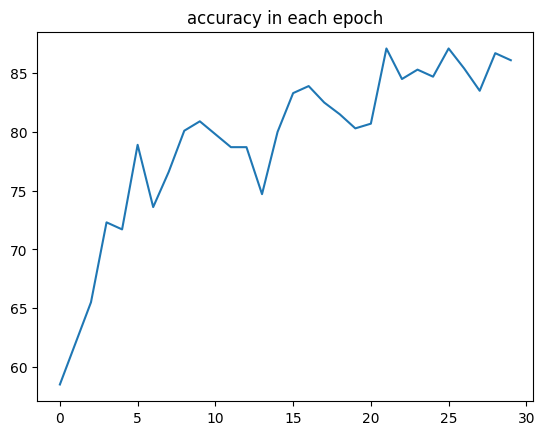

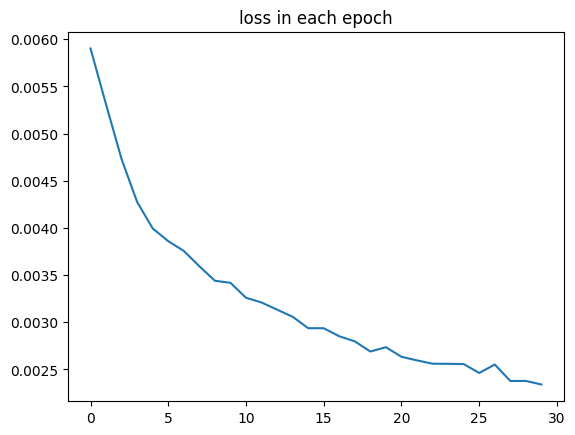

In [ ]:
import numpy as np

plt.plot(np.arange(NUM_EPOCHS), accuracies)
plt.title("accuracy in each epoch")
plt.show()
plt.plot(np.arange(NUM_EPOCHS), loss_in_each_epoch)
plt.title("loss in each epoch")
plt.show()

دقت داده های تست

In [ ]:
net.eval()
print ("validation accuracy = ", end = "")
get_accuracy(net, testloader)

validation accuracy = Accuracy of the network: 88.6500015258789 %
Accuracy of airplane: 91.2 %
Accuracy of automobile: 86.1 %


86.1

دو بلوک زیر مهم نیست

In [ ]:
# developement stuff!
# labels = [0,1]
# num_data1 = 50
# pos_neg = [random.sample(labels, k=2) for i in range(num_data1)]
# anc_idx = []
# pos_idx = []
# neg_idx = []
# classes_labels = [[0,2,4,6,8,12,10,14,16],[1,3,5,7,9,11,13,15,17,19]]
# for pos,neg in pos_neg:
#   anc_idx.append(random.sample(classes_labels[pos], k=1))
#   pos_idx.append(random.sample(classes_labels[pos], k=1))
#   neg_idx.append(random.sample(classes_labels[neg],k=1))
# print(anc_idx)
# print(pos_idx)
# print(neg_idx)

[[14], [5], [9], [8], [3], [10], [5], [15], [0], [4], [19], [0], [9], [7], [9], [1], [2], [5], [1], [7], [15], [10], [16], [19], [12], [0], [16], [14], [16], [1], [16], [17], [5], [4], [9], [8], [7], [0], [8], [9], [11], [17], [12], [7], [16], [16], [15], [12], [17], [5]]

[[2], [15], [9], [6], [3], [12], [11], [1], [10], [14], [11], [10], [7], [15], [1], [9], [10], [7], [1], [13], [17], [8], [12], [19], [0], [4], [16], [8], [2], [3], [12], [9], [5], [0], [15], [2], [1], [12], [6], [3], [15], [5], [0], [19], [12], [2], [3], [8], [15], [1]]

[[7], [14], [0], [3], [10], [15], [6], [16], [7], [9], [12], [13], [16], [6], [4], [14], [17], [14], [14], [6], [10], [15], [3], [2], [3], [15], [11], [7], [13], [6], [11], [8], [4], [13], [0], [17], [14], [11], [1], [14], [16], [4], [13], [0], [11], [5], [16], [7], [16], [6]]


In [ ]:
# # Define a population list
# population = [1, 2, 3, 4, 5]

# # Generate a random sample of size 3 from the population list
# random_sample = random.sample(population, k=3)

# print("Random Sample:", random_sample)

Random Sample: [5, 1, 4]


In [ ]:
for i in range(100):
  x,y = train_subset[i]
  print(i,y)

در کلاس دیتاست تریپلت ابتدا اندیس های هر کلاس را پیدا می کنیم و برای هر نمونه دیتاست، برای انکر و پازتیو یک کلاس یکسان و برای نگاتیو یک کلاس متفاوت با آن را در نظر می گیریم.
به این صورت که برای پازتیو ها و انکر به صورت رندوم یک کلاس انتخاب می شود و نگاتیو هم کلاس های باقیمانده می شود و برای هرکدام دوباره به صورت رندوم از اندیس های آن کلاس رندوم سمپل می کنیم.

In [ ]:

class triplt_loss_dataset(Dataset):   #the class is compatible foe multiple class triplet
    def __init__(self,dataset, classes,num_data=8000):

        self.dataset = dataset
        self.num_data = num_data
        self.classes = classes
        class_indices = defaultdict(list)
        classes_labels = [i for i in range(len(self.classes))]
        # we should find a list that has indices of each class in input dataset
        # iterate through the dataset and store indices for each class
        print("generating the dataset indices!...")
        for idx, (image, label) in enumerate(dataset):
            class_indices[label].append(idx)
        print("len(dataset.classes)",self.classes)
        indices_list = [class_indices[i] for i in range(len(self.classes))]
        self.indices = indices_list
        pos_neg = [random.sample(classes_labels, k=2) for i in range(self.num_data)]
        self.anc_idx = []
        self.pos_idx = []
        self.neg_idx = []
        for pos, neg in tqdm(pos_neg):
          self.anc_idx.append(random.sample(self.indices[pos], k=1)[0])
          self.pos_idx.append(random.sample(self.indices[pos], k=1)[0])
          self.neg_idx.append(random.sample(self.indices[neg],k=1)[0])

        # print(self.anc_idx)
        # print(self.pos_idx)
        # print(self.neg_idx)

    def __getitem__(self,idx):
        idx = idx % self.num_data
        anc_data, label = self.dataset[self.anc_idx[idx]]
        pos_data, label = self.dataset[self.pos_idx[idx]]
        neg_data, label = self.dataset[self.neg_idx[idx]]
        return (anc_data, pos_data, neg_data)

    def __len__(self):
      return self.num_data
      #


In [ ]:
triplet = triplt_loss_dataset(train_subset ,classes = classes_to_keep,num_data=8000)


generating the dataset indices!...

len(dataset.classes) ('airplane', 'automobile')


100%|██████████| 8000/8000 [00:00<00:00, 183655.62it/s]


In [ ]:
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np

def visualize_triplet_dataset(dataset, num_images=5,classes_to_keep=classes_to_keep):
    classes = classes_to_keep
    indices = np.random.randint(0, len(dataset), num_images)

    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))
    for i, idx in enumerate(indices):
        anc, pos, neg = dataset[idx]
        anc = anc.numpy().transpose((1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        anc = std * anc + mean
        anc = np.clip(anc, 0, 1)

        pos = pos.numpy().transpose((1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        pos = std * pos + mean
        pos = np.clip(pos, 0, 1)

        neg = neg.numpy().transpose((1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        neg = std * neg + mean
        neg = np.clip(neg, 0, 1)

        image = np.vstack([anc, pos, neg])

        axes[i].imshow(image)
        axes[i].set_title("anc,pos,neg")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()



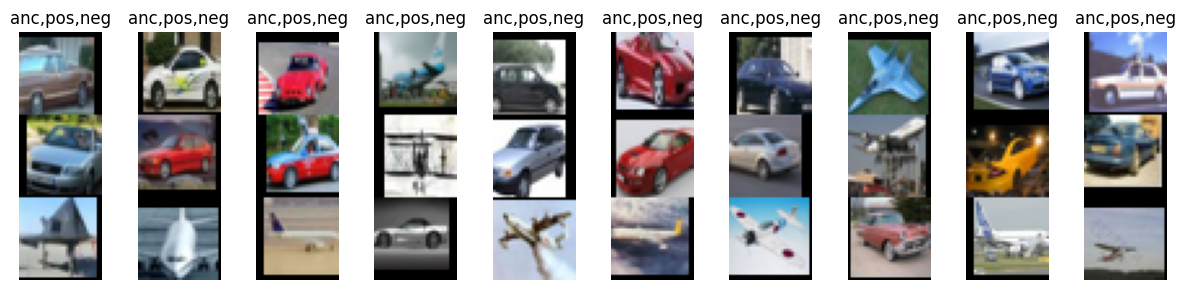

In [ ]:
# visualize samples of dataset
visualize_triplet_dataset(triplet, num_images=10,classes_to_keep=classes_to_keep)  # Change num_images to visualize more or fewer images


برای مقایسه ی خاصیت جداکردن تریپلت، آن ها ابتدا دیتاست به صورت کاهش بعد یافته قبل از اعمال این آبجکتیو فانکشن را با استفاده از کتابخانه یو-مپ پلات می کنیم

In [ ]:
!pip install umap-learn
import umap
import numpy as np
import matplotlib.pyplot as plt


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
def umap_visualizer(loader, model):
  model.eval()
  data_list = []
  with torch.no_grad():
      n_correct = 0
      n_samples = 0
      n_class_correct = [0 for i in range(2)]
      n_class_samples = [0 for i in range(2)]
      for images, labels in loader:
          images = images.to(device)
          labels = labels.to(device)
          # print(labels)
          outputs, embeddings = model(images)
          # max returns (value ,index)
          data_list.append(embeddings.to("cpu").numpy())

  data = np.concatenate(data_list, axis=0)
  umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)

  # Fit the UMAP model to your data
  umap_result = umap_model.fit_transform(data)

  plt.scatter(umap_result[:, 0], umap_result[:, 1], s=5, cmap='viridis')
  plt.title('UMAP Visualization')
  plt.xlabel('UMAP Dimension 1')
  plt.ylabel('UMAP Dimension 2')
  plt.show()

/tmp/ipykernel_42/665295112.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_result[:, 0], umap_result[:, 1], s=5, cmap='viridis')


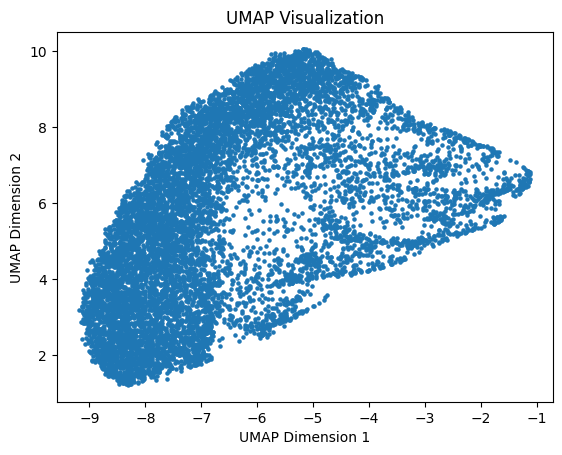

In [ ]:
umap_visualizer(trainloader, net)

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, alpha=1.0):
        super(TripletLoss, self).__init__()
        self.max0 = nn.ReLU()
        self.alpha = alpha

    def forward(self, anchor, positive, negative):
        distance_pos = torch.norm(anchor - positive, dim=1)
        distance_neg = torch.norm(anchor - negative, dim=1)
        losses = self.max0(distance_pos - distance_neg + self.alpha)#max( , 0)
        return torch.mean(losses)


In [ ]:
triplet = triplt_loss_dataset(train_subset ,classes = classes_to_keep,num_data=10000)
tripletloader = torch.utils.data.DataLoader(triplet, batch_size=batch_size, shuffle=True, num_workers=2)

criterion2 = TripletLoss()

generating the dataset indices!...
len(dataset.classes) ('airplane', 'automobile')


100%|██████████| 10000/10000 [00:00<00:00, 85307.99it/s]


In [ ]:

NUM_EPOCHS = 60
loss_in_each_epoch = []
accuracies = []
for epoch in range(NUM_EPOCHS):
  net.train()
  print('\nEpoch: %d' % (epoch+1))
  net.train()
  train_loss = 0
  correct = 0
  total = 0
  for batch_idx, (anc, pos, neg) in enumerate(tqdm(tripletloader)):
    anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)
    optimizer.zero_grad()
    _,embeddings_anc = net(anc)
    _,embeddings_pos = net(pos)
    _,embeddings_neg = net(neg)
    # print(outputs.shape, targets.shape)

    loss = criterion2(embeddings_anc, embeddings_pos, embeddings_neg)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    total += anc.size(0)
  loss_in_each_epoch.append(train_loss/total)


Epoch: 1


100%|██████████| 79/79 [00:17<00:00,  4.45it/s]



Epoch: 2


100%|██████████| 79/79 [00:17<00:00,  4.40it/s]



Epoch: 3


100%|██████████| 79/79 [00:17<00:00,  4.50it/s]



Epoch: 4


100%|██████████| 79/79 [00:17<00:00,  4.55it/s]



Epoch: 5


100%|██████████| 79/79 [00:17<00:00,  4.56it/s]



Epoch: 6


100%|██████████| 79/79 [00:17<00:00,  4.52it/s]



Epoch: 7


100%|██████████| 79/79 [00:17<00:00,  4.51it/s]



Epoch: 8


100%|██████████| 79/79 [00:17<00:00,  4.53it/s]



Epoch: 9


100%|██████████| 79/79 [00:17<00:00,  4.52it/s]



Epoch: 10


100%|██████████| 79/79 [00:17<00:00,  4.52it/s]



Epoch: 11


100%|██████████| 79/79 [00:17<00:00,  4.51it/s]



Epoch: 12


100%|██████████| 79/79 [00:17<00:00,  4.53it/s]



Epoch: 13


100%|██████████| 79/79 [00:17<00:00,  4.50it/s]



Epoch: 14


100%|██████████| 79/79 [00:17<00:00,  4.53it/s]



Epoch: 15


100%|██████████| 79/79 [00:17<00:00,  4.52it/s]



Epoch: 16


100%|██████████| 79/79 [00:17<00:00,  4.51it/s]



Epoch: 17


100%|██████████| 79/79 [00:17<00:00,  4.50it/s]



Epoch: 18


100%|██████████| 79/79 [00:17<00:00,  4.52it/s]



Epoch: 19


100%|██████████| 79/79 [00:17<00:00,  4.51it/s]



Epoch: 20


100%|██████████| 79/79 [00:17<00:00,  4.49it/s]



Epoch: 21


100%|██████████| 79/79 [00:17<00:00,  4.52it/s]



Epoch: 22


100%|██████████| 79/79 [00:17<00:00,  4.50it/s]



Epoch: 23


100%|██████████| 79/79 [00:17<00:00,  4.53it/s]



Epoch: 24


100%|██████████| 79/79 [00:17<00:00,  4.52it/s]



Epoch: 25


100%|██████████| 79/79 [00:17<00:00,  4.51it/s]



Epoch: 26


100%|██████████| 79/79 [00:17<00:00,  4.52it/s]



Epoch: 27


100%|██████████| 79/79 [00:17<00:00,  4.51it/s]



Epoch: 28


100%|██████████| 79/79 [00:17<00:00,  4.52it/s]



Epoch: 29


100%|██████████| 79/79 [00:17<00:00,  4.49it/s]



Epoch: 30


100%|██████████| 79/79 [00:17<00:00,  4.50it/s]



Epoch: 31


100%|██████████| 79/79 [00:17<00:00,  4.49it/s]



Epoch: 32


100%|██████████| 79/79 [00:17<00:00,  4.53it/s]



Epoch: 33


100%|██████████| 79/79 [00:17<00:00,  4.53it/s]



Epoch: 34


100%|██████████| 79/79 [00:17<00:00,  4.52it/s]



Epoch: 35


100%|██████████| 79/79 [00:17<00:00,  4.50it/s]



Epoch: 36


100%|██████████| 79/79 [00:17<00:00,  4.52it/s]



Epoch: 37


100%|██████████| 79/79 [00:17<00:00,  4.52it/s]



Epoch: 38


100%|██████████| 79/79 [00:17<00:00,  4.50it/s]



Epoch: 39


100%|██████████| 79/79 [00:17<00:00,  4.52it/s]



Epoch: 40


100%|██████████| 79/79 [00:17<00:00,  4.51it/s]



Epoch: 41


100%|██████████| 79/79 [00:17<00:00,  4.52it/s]



Epoch: 42


100%|██████████| 79/79 [00:17<00:00,  4.53it/s]



Epoch: 43


100%|██████████| 79/79 [00:17<00:00,  4.53it/s]



Epoch: 44


100%|██████████| 79/79 [00:17<00:00,  4.51it/s]



Epoch: 45


100%|██████████| 79/79 [00:17<00:00,  4.52it/s]



Epoch: 46


100%|██████████| 79/79 [00:17<00:00,  4.54it/s]



Epoch: 47


100%|██████████| 79/79 [00:17<00:00,  4.51it/s]



Epoch: 48


100%|██████████| 79/79 [00:17<00:00,  4.53it/s]



Epoch: 49


100%|██████████| 79/79 [00:17<00:00,  4.52it/s]



Epoch: 50


100%|██████████| 79/79 [00:17<00:00,  4.52it/s]



Epoch: 51


100%|██████████| 79/79 [00:17<00:00,  4.52it/s]



Epoch: 52


100%|██████████| 79/79 [00:17<00:00,  4.52it/s]



Epoch: 53


100%|██████████| 79/79 [00:17<00:00,  4.52it/s]



Epoch: 54


100%|██████████| 79/79 [00:17<00:00,  4.52it/s]



Epoch: 55


100%|██████████| 79/79 [00:17<00:00,  4.55it/s]



Epoch: 56


100%|██████████| 79/79 [00:17<00:00,  4.53it/s]



Epoch: 57


100%|██████████| 79/79 [00:17<00:00,  4.54it/s]



Epoch: 58


100%|██████████| 79/79 [00:17<00:00,  4.53it/s]



Epoch: 59


100%|██████████| 79/79 [00:17<00:00,  4.52it/s]



Epoch: 60


100%|██████████| 79/79 [00:17<00:00,  4.54it/s]


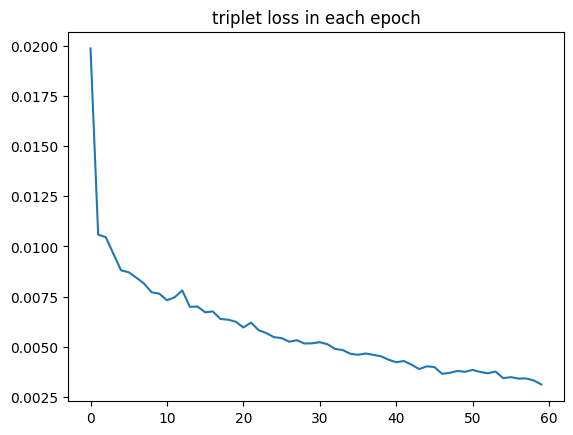

In [ ]:

plt.plot(np.arange(NUM_EPOCHS), loss_in_each_epoch)
plt.title("triplet loss in each epoch")
plt.show()

/tmp/ipykernel_42/665295112.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_result[:, 0], umap_result[:, 1], s=5, cmap='viridis')


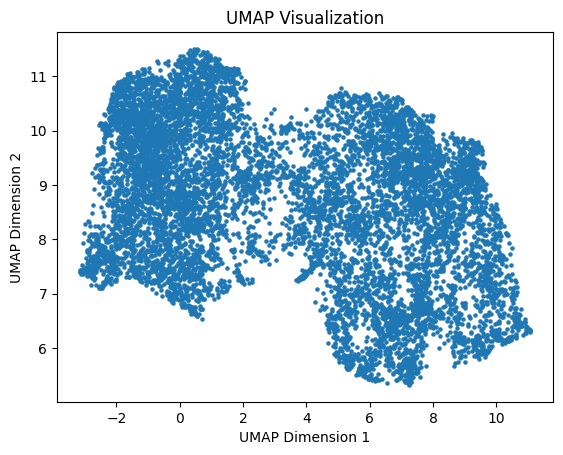

In [ ]:
umap_visualizer(trainloader, net)

مشاهده می کنیم این ابجکتیو فانکشن یک خاصیت جداپذیری به این امبدینگ ها داده است

In [ ]:
for name, param in net.named_parameters():
    if 'fc' not in name:  # Freeze all layers except fc
        param.requires_grad = False

# Defining the classifier after the embeddings
برای آموزش این کلاسیفایر از همان لایه فولی کانکتد آخر مدل استفاده می کنیم . فقط چون از لایه های قبل صرفا به عنوان فیچراکسترکتر استفاده می کنیم آن ها را آپدیت نمی کنیم پس گرادیان آن ها را خاموش می کنیم. به غیر از لایه آخر

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-4,momentum=0.9, weight_decay=5e-4)
NUM_EPOCHS = 30
loss_in_each_epoch = []
accuracies = []
for epoch in range(NUM_EPOCHS):
  net.train()
  print('\nEpoch: %d' % (epoch+1))
  net.train()
  train_loss = 0
  correct = 0
  total = 0
  for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs,_ = net(inputs)
    # print(outputs.shape, targets.shape)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = outputs.max(1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()
  accuracies.append(get_accuracy(net, trainloader))
  loss_in_each_epoch.append(train_loss/total)



Epoch: 1


100%|██████████| 79/79 [00:02<00:00, 27.82it/s]


Accuracy of the network: 92.30000305175781 %
Accuracy of airplane: 94.3 %
Accuracy of automobile: 90.3 %

Epoch: 2


100%|██████████| 79/79 [00:02<00:00, 28.67it/s]


Accuracy of the network: 92.50000762939453 %
Accuracy of airplane: 94.5 %
Accuracy of automobile: 90.5 %

Epoch: 3


100%|██████████| 79/79 [00:02<00:00, 27.71it/s]


Accuracy of the network: 92.4000015258789 %
Accuracy of airplane: 93.7 %
Accuracy of automobile: 91.1 %

Epoch: 4


100%|██████████| 79/79 [00:02<00:00, 26.71it/s]


Accuracy of the network: 92.45000457763672 %
Accuracy of airplane: 94.3 %
Accuracy of automobile: 90.6 %

Epoch: 5


100%|██████████| 79/79 [00:02<00:00, 28.16it/s]


Accuracy of the network: 92.50000762939453 %
Accuracy of airplane: 94.0 %
Accuracy of automobile: 91.0 %

Epoch: 6


100%|██████████| 79/79 [00:02<00:00, 27.09it/s]


Accuracy of the network: 92.45000457763672 %
Accuracy of airplane: 93.2 %
Accuracy of automobile: 91.7 %

Epoch: 7


100%|██████████| 79/79 [00:02<00:00, 28.55it/s]


Accuracy of the network: 92.80000305175781 %
Accuracy of airplane: 92.8 %
Accuracy of automobile: 92.8 %

Epoch: 8


100%|██████████| 79/79 [00:02<00:00, 27.63it/s]


Accuracy of the network: 92.60000610351562 %
Accuracy of airplane: 93.3 %
Accuracy of automobile: 91.9 %

Epoch: 9


100%|██████████| 79/79 [00:02<00:00, 27.16it/s]


Accuracy of the network: 92.60000610351562 %
Accuracy of airplane: 94.0 %
Accuracy of automobile: 91.2 %

Epoch: 10


100%|██████████| 79/79 [00:02<00:00, 27.38it/s]


Accuracy of the network: 92.35000610351562 %
Accuracy of airplane: 94.4 %
Accuracy of automobile: 90.3 %

Epoch: 11


100%|██████████| 79/79 [00:02<00:00, 27.73it/s]


Accuracy of the network: 92.35000610351562 %
Accuracy of airplane: 94.8 %
Accuracy of automobile: 89.9 %

Epoch: 12


100%|██████████| 79/79 [00:02<00:00, 27.29it/s]


Accuracy of the network: 92.70000457763672 %
Accuracy of airplane: 92.0 %
Accuracy of automobile: 93.4 %

Epoch: 13


100%|██████████| 79/79 [00:02<00:00, 26.67it/s]


Accuracy of the network: 92.70000457763672 %
Accuracy of airplane: 93.5 %
Accuracy of automobile: 91.9 %

Epoch: 14


100%|██████████| 79/79 [00:02<00:00, 26.63it/s]


Accuracy of the network: 92.75000762939453 %
Accuracy of airplane: 93.6 %
Accuracy of automobile: 91.9 %

Epoch: 15


100%|██████████| 79/79 [00:02<00:00, 27.42it/s]


Accuracy of the network: 92.75000762939453 %
Accuracy of airplane: 92.8 %
Accuracy of automobile: 92.7 %

Epoch: 16


100%|██████████| 79/79 [00:02<00:00, 27.69it/s]


Accuracy of the network: 92.30000305175781 %
Accuracy of airplane: 94.3 %
Accuracy of automobile: 90.3 %

Epoch: 17


100%|██████████| 79/79 [00:02<00:00, 27.98it/s]


Accuracy of the network: 92.70000457763672 %
Accuracy of airplane: 92.6 %
Accuracy of automobile: 92.8 %

Epoch: 18


100%|██████████| 79/79 [00:02<00:00, 27.15it/s]


Accuracy of the network: 92.70000457763672 %
Accuracy of airplane: 92.7 %
Accuracy of automobile: 92.7 %

Epoch: 19


100%|██████████| 79/79 [00:02<00:00, 27.21it/s]


Accuracy of the network: 92.30000305175781 %
Accuracy of airplane: 93.3 %
Accuracy of automobile: 91.3 %

Epoch: 20


100%|██████████| 79/79 [00:02<00:00, 28.87it/s]


Accuracy of the network: 92.6500015258789 %
Accuracy of airplane: 92.9 %
Accuracy of automobile: 92.4 %

Epoch: 21


100%|██████████| 79/79 [00:03<00:00, 25.95it/s]


Accuracy of the network: 92.6500015258789 %
Accuracy of airplane: 92.5 %
Accuracy of automobile: 92.8 %

Epoch: 22


100%|██████████| 79/79 [00:02<00:00, 27.73it/s]


Accuracy of the network: 92.45000457763672 %
Accuracy of airplane: 93.4 %
Accuracy of automobile: 91.5 %

Epoch: 23


100%|██████████| 79/79 [00:03<00:00, 25.99it/s]


Accuracy of the network: 92.45000457763672 %
Accuracy of airplane: 92.6 %
Accuracy of automobile: 92.3 %

Epoch: 24


100%|██████████| 79/79 [00:02<00:00, 28.05it/s]


Accuracy of the network: 92.30000305175781 %
Accuracy of airplane: 93.7 %
Accuracy of automobile: 90.9 %

Epoch: 25


100%|██████████| 79/79 [00:02<00:00, 27.07it/s]


Accuracy of the network: 92.80000305175781 %
Accuracy of airplane: 93.3 %
Accuracy of automobile: 92.3 %

Epoch: 26


100%|██████████| 79/79 [00:02<00:00, 27.46it/s]


Accuracy of the network: 92.75000762939453 %
Accuracy of airplane: 93.6 %
Accuracy of automobile: 91.9 %

Epoch: 27


100%|██████████| 79/79 [00:02<00:00, 28.32it/s]


Accuracy of the network: 92.30000305175781 %
Accuracy of airplane: 94.2 %
Accuracy of automobile: 90.4 %

Epoch: 28


100%|██████████| 79/79 [00:02<00:00, 27.53it/s]


Accuracy of the network: 92.45000457763672 %
Accuracy of airplane: 93.9 %
Accuracy of automobile: 91.0 %

Epoch: 29


100%|██████████| 79/79 [00:02<00:00, 28.35it/s]


Accuracy of the network: 92.45000457763672 %
Accuracy of airplane: 93.8 %
Accuracy of automobile: 91.1 %

Epoch: 30


100%|██████████| 79/79 [00:03<00:00, 26.20it/s]


Accuracy of the network: 92.4000015258789 %
Accuracy of airplane: 93.3 %
Accuracy of automobile: 91.5 %


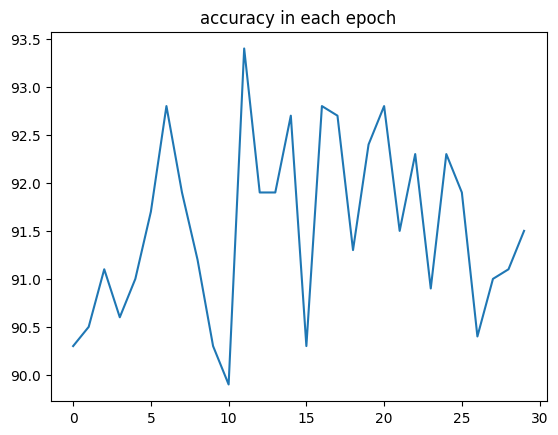

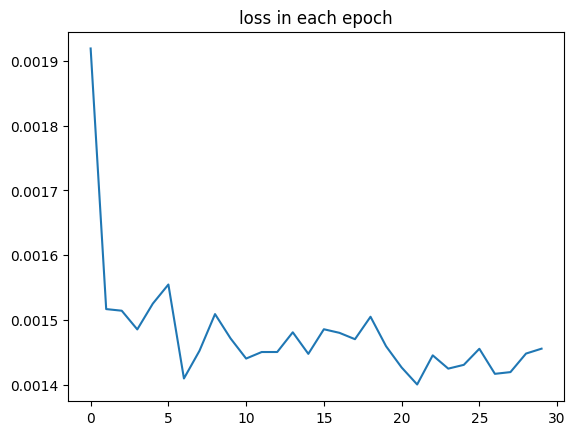

In [ ]:
plt.plot(np.arange(NUM_EPOCHS), accuracies)
plt.title("accuracy in each epoch")
plt.show()
plt.plot(np.arange(NUM_EPOCHS), loss_in_each_epoch)
plt.title("loss in each epoch")
plt.show()

In [ ]:
net.eval()
print ("validation accuracy = ", end = "")
get_accuracy(net, testloader)

validation accuracy = Accuracy of the network: 92.4000015258789 %
Accuracy of airplane: 93.3 %
Accuracy of automobile: 91.5 %


91.5

# 2 loss functions at the same time

ابتدا تمام گرادیان های شبکه را روشن می کنیم . سپس قسمت مهم دادن دیتاست ها به صورت همزمان است. به این صورت که دیتاست معمولی و تریپلت به صورت همزمان داده می شوند پس تعداد آن ها را یکسان تعریف می کنیم.سپس پس از دادن یک بچ از هر دیتاست، لاس ها هر کدام را با هم جمع می کنیم و گرادیان می گیریم.

In [ ]:
for name, param in net.named_parameters():
    param.requires_grad = True

In [ ]:
criterion1 = nn.CrossEntropyLoss()
NUM_EPOCHS = 30
loss_in_each_epoch = []
accuracies = []
for epoch in range(NUM_EPOCHS):
  net.train()
  print('\nEpoch: %d' % (epoch+1))
  train_loss = 0
  correct = 0
  total = 0
  for batch_idx, (anc, pos, neg) in enumerate(tqdm(tripletloader)):
    inputs, targets = next(iter(trainloader))
    inputs, targets = inputs.to(device), targets.to(device)
    anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)
    optimizer.zero_grad()
    _,embeddings_anc = net(anc)
    _,embeddings_pos = net(pos)
    _,embeddings_neg = net(neg)
    # print(outputs.shape, targets.shape)
    outputs,_ = net(inputs)
    # print(outputs.shape, targets.shape)
    loss1 = criterion1(outputs, targets)
    loss2 = criterion2(embeddings_anc, embeddings_pos, embeddings_neg)
    loss = loss1 + loss2
    loss.backward()
    optimizer.step()

    total += anc.size(0)
    train_loss += loss.item()
    _, predicted = outputs.max(1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()
  accuracies.append(get_accuracy(net, trainloader))
  loss_in_each_epoch.append(train_loss/total)


Epoch: 1


100%|██████████| 79/79 [00:49<00:00,  1.59it/s]


Accuracy of the network: 92.6500015258789 %
Accuracy of airplane: 94.4 %
Accuracy of automobile: 90.9 %

Epoch: 2


100%|██████████| 79/79 [00:48<00:00,  1.62it/s]


Accuracy of the network: 92.70000457763672 %
Accuracy of airplane: 93.3 %
Accuracy of automobile: 92.1 %

Epoch: 3


100%|██████████| 79/79 [01:09<00:00,  1.14it/s]


Accuracy of the network: 92.85000610351562 %
Accuracy of airplane: 91.5 %
Accuracy of automobile: 94.2 %

Epoch: 4


100%|██████████| 79/79 [00:49<00:00,  1.60it/s]


Accuracy of the network: 92.70000457763672 %
Accuracy of airplane: 93.8 %
Accuracy of automobile: 91.6 %

Epoch: 5


100%|██████████| 79/79 [00:49<00:00,  1.59it/s]


Accuracy of the network: 93.45000457763672 %
Accuracy of airplane: 92.8 %
Accuracy of automobile: 94.1 %

Epoch: 6


100%|██████████| 79/79 [00:49<00:00,  1.58it/s]


Accuracy of the network: 93.80000305175781 %
Accuracy of airplane: 93.8 %
Accuracy of automobile: 93.8 %

Epoch: 7


100%|██████████| 79/79 [00:49<00:00,  1.60it/s]


Accuracy of the network: 93.45000457763672 %
Accuracy of airplane: 94.2 %
Accuracy of automobile: 92.7 %

Epoch: 8


100%|██████████| 79/79 [00:49<00:00,  1.59it/s]


Accuracy of the network: 93.1500015258789 %
Accuracy of airplane: 92.5 %
Accuracy of automobile: 93.8 %

Epoch: 9


100%|██████████| 79/79 [00:49<00:00,  1.59it/s]


Accuracy of the network: 92.70000457763672 %
Accuracy of airplane: 96.2 %
Accuracy of automobile: 89.2 %

Epoch: 10


100%|██████████| 79/79 [00:49<00:00,  1.60it/s]


Accuracy of the network: 93.60000610351562 %
Accuracy of airplane: 91.9 %
Accuracy of automobile: 95.3 %

Epoch: 11


100%|██████████| 79/79 [00:49<00:00,  1.60it/s]


Accuracy of the network: 93.60000610351562 %
Accuracy of airplane: 94.2 %
Accuracy of automobile: 93.0 %

Epoch: 12


100%|██████████| 79/79 [00:50<00:00,  1.58it/s]


Accuracy of the network: 93.50000762939453 %
Accuracy of airplane: 94.4 %
Accuracy of automobile: 92.6 %

Epoch: 13


100%|██████████| 79/79 [00:50<00:00,  1.57it/s]


Accuracy of the network: 93.35000610351562 %
Accuracy of airplane: 96.6 %
Accuracy of automobile: 90.1 %

Epoch: 14


100%|██████████| 79/79 [00:50<00:00,  1.57it/s]


Accuracy of the network: 93.25000762939453 %
Accuracy of airplane: 96.1 %
Accuracy of automobile: 90.4 %

Epoch: 15


100%|██████████| 79/79 [00:50<00:00,  1.58it/s]


Accuracy of the network: 93.55000305175781 %
Accuracy of airplane: 95.6 %
Accuracy of automobile: 91.5 %

Epoch: 16


100%|██████████| 79/79 [00:50<00:00,  1.58it/s]


Accuracy of the network: 93.55000305175781 %
Accuracy of airplane: 94.0 %
Accuracy of automobile: 93.1 %

Epoch: 17


100%|██████████| 79/79 [00:50<00:00,  1.58it/s]


Accuracy of the network: 94.00000762939453 %
Accuracy of airplane: 96.0 %
Accuracy of automobile: 92.0 %

Epoch: 18


100%|██████████| 79/79 [00:49<00:00,  1.59it/s]


Accuracy of the network: 93.45000457763672 %
Accuracy of airplane: 96.2 %
Accuracy of automobile: 90.7 %

Epoch: 19


100%|██████████| 79/79 [00:49<00:00,  1.58it/s]


Accuracy of the network: 94.20000457763672 %
Accuracy of airplane: 93.2 %
Accuracy of automobile: 95.2 %

Epoch: 20


100%|██████████| 79/79 [00:50<00:00,  1.56it/s]


Accuracy of the network: 94.30000305175781 %
Accuracy of airplane: 94.8 %
Accuracy of automobile: 93.8 %

Epoch: 21


100%|██████████| 79/79 [00:50<00:00,  1.56it/s]


Accuracy of the network: 93.70000457763672 %
Accuracy of airplane: 95.2 %
Accuracy of automobile: 92.2 %

Epoch: 22


100%|██████████| 79/79 [00:50<00:00,  1.56it/s]


Accuracy of the network: 94.60000610351562 %
Accuracy of airplane: 95.3 %
Accuracy of automobile: 93.9 %

Epoch: 23


100%|██████████| 79/79 [00:50<00:00,  1.58it/s]


Accuracy of the network: 94.80000305175781 %
Accuracy of airplane: 94.7 %
Accuracy of automobile: 94.9 %

Epoch: 24


100%|██████████| 79/79 [00:50<00:00,  1.57it/s]


Accuracy of the network: 94.00000762939453 %
Accuracy of airplane: 94.4 %
Accuracy of automobile: 93.6 %

Epoch: 25


100%|██████████| 79/79 [00:50<00:00,  1.57it/s]


Accuracy of the network: 94.00000762939453 %
Accuracy of airplane: 94.4 %
Accuracy of automobile: 93.6 %

Epoch: 26


100%|██████████| 79/79 [00:50<00:00,  1.56it/s]


Accuracy of the network: 93.9000015258789 %
Accuracy of airplane: 93.9 %
Accuracy of automobile: 93.9 %

Epoch: 27


100%|██████████| 79/79 [00:50<00:00,  1.56it/s]


Accuracy of the network: 94.45000457763672 %
Accuracy of airplane: 94.7 %
Accuracy of automobile: 94.2 %

Epoch: 28


100%|██████████| 79/79 [00:50<00:00,  1.56it/s]


Accuracy of the network: 94.30000305175781 %
Accuracy of airplane: 94.1 %
Accuracy of automobile: 94.5 %

Epoch: 29


100%|██████████| 79/79 [00:50<00:00,  1.57it/s]


Accuracy of the network: 92.95000457763672 %
Accuracy of airplane: 97.3 %
Accuracy of automobile: 88.6 %

Epoch: 30


100%|██████████| 79/79 [00:50<00:00,  1.57it/s]


Accuracy of the network: 94.25000762939453 %
Accuracy of airplane: 95.5 %
Accuracy of automobile: 93.0 %


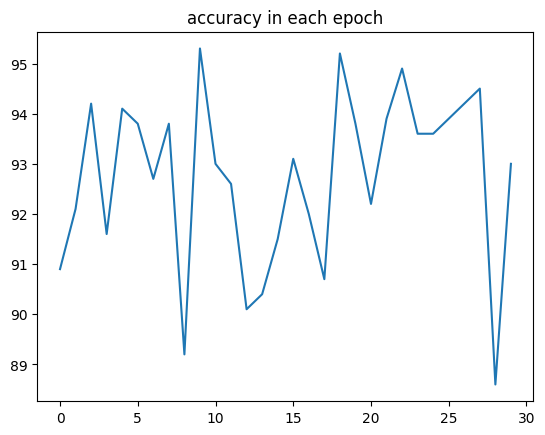

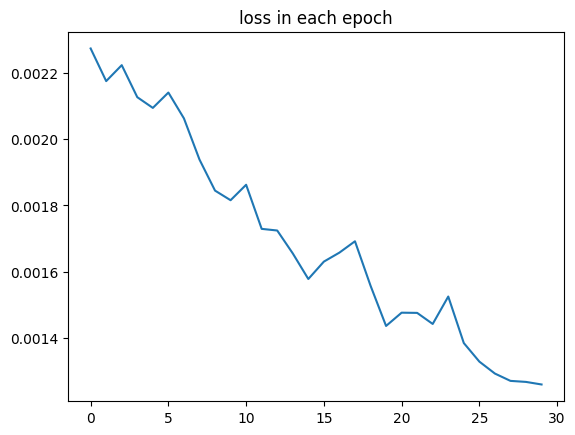

validation accuracy = Accuracy of the network: 94.25000762939453 %
Accuracy of airplane: 95.5 %
Accuracy of automobile: 93.0 %


93.0

In [ ]:
plt.plot(np.arange(NUM_EPOCHS), accuracies)
plt.title("accuracy in each epoch")
plt.show()
plt.plot(np.arange(NUM_EPOCHS), loss_in_each_epoch)
plt.title("loss in each epoch")
plt.show()

net.eval()
print ("validation accuracy = ", end = "")
get_accuracy(net, testloader)

در آموزش متوالی فقط یک بار مدل را تعریف کردیم پس در هر مرحله از پارمتر های مرحله ی قبل استفاده شد و از صفر شروع نکردیم.